# Resumen del trabajo realizado
Este notebook incluye la construcción y desarrollo de nuestra red clasificadora base. Los otros notebooks que adjuntamos incluyen diferentes intentos para mejorar el accuracy en el set de validación. 

Para poder **comparar los distintos intentos con igual criterio**, la regla seguida ha sido parar el entrenamiento cuando se cumpla alguna de las condiciones siguientes: 

* Se completan 100 epochs
* La pérdida (entropía cruzada) del set de validación no mejora durante 5 epochs seguidos.

A continuación describimos brevemente los diferentes intentos y la *accuracy* obtenida. Para más detalles, ver cada uno de los notebooks.

* **Modelo base**: Empleando la arquitectura y parámetros de entrenamiento descritos en este notebook, obtenemos una ***accuracy* en validación del ~80.0%**
* **Intento 2: Base + Dropout del 20%**: obtenemos una ***accuracy* en validación del ~80.6%**
* **Intento 3: Resize + Base + Dropout del 30%**: obtenemos una ***accuracy* en validación del ~78.1%**
* **Intento 4: Resize + Base + Dropout del 50%**: obtenemos una ***accuracy* en validación del ~81.5%**
* **Intento 5: Resize + Base + Batch más pequeño**: obtenemos una ***accuracy* en validación del ~82.3%**
* **Intento 6: Resize + Base + Conv. adicional**: obtenemos una ***accuracy* en validación del ~83.5%**
* **Intento 7: Resize 128 + Multiple capa VGG con normalización + Dropout**: obtenemos una ***accuracy* en validación del ~89,15%**. En este intento se apilan varias capas convolucionales seguidas de max-pooling. El número de filtros de cada capa aumenta conforme más profunda es la red, doblando el número en cada nivel. Se añade en cada bloque un dropout para ayudar a reducir overfitting reduciendo la dependencia entre neuronas. Además se usa batch normalization para normalizar cada lote de datos y mejorar el rendimiento de la red.
* **Intento 8: Arquitectura alternativa inspirada en ResNet**: hemos implementado una arquitectura inspirada en ResNet, aunque más ligera. Lo que hemos "tomado" de ResNet es el uso de *residual units* (también llamados *connection shortcuts*) para evitar que el gradiente tienda a cero cuando usamos un mayor número de capas (el efecto *vanishing gradients*), además de usar varios bloques de convoluciones y capas de pooling similares a las usadas en la ResNet. Obtenemos una ***accuracy* en validación del ~85.5%** con un modelo que tiene **~10 veces menos parámetros** que el modelo base.

Nota, los valores del *accuracy* llevan el prefijo "~" para indicar que son aproximados ya que dependen de la iniciación aleatoria de los pesos. La *accuracy* que reportamos aquí es la obtenida al final del epoch con menor pérdida en validación, no la obtenida en el último epoch. Esto lo hacemos así porque en una aplicación real, lo que haríamos sería ir guardando *checkpoints* al final de cada epoch, y al final del entrenamiento revertiríamos los pesos del modelo a los pesos obtenidos al final de dicho epoch (el que tiene menor pérdida en validación). 

# Modelo base

## 0. Descarga del dataset

In [9]:
# from google.colab import drive
# drive.mount('/content/drive')

train_ds_path  ='../../deeplearning-az/datasets/' \
                'Part 2 - Convolutional Neural Networks (CNN)/dataset/training_set'
test_ds_path   ='../../deeplearning-az/datasets/' \
                'Part 2 - Convolutional Neural Networks (CNN)/dataset/test_set'
cat_or_dog_path='../../deeplearning-az/datasets/' \
                'Part 2 - Convolutional Neural Networks (CNN)/dataset/single_prediction/cat_or_dog_1.jpg'


train_ds_path  ='.\\data\\training_set'
test_ds_path   ='.\\data\\test_set'
cat_or_dog_path='.\\data\\single_prediction\\cat_or_dog_1.jpg'


Primero, importar las librerías y paquetes

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
# Nota, algunas capas no están importadas aquí y se importan directamente en el código con tf.keras.laters.[CAPA]

import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
import random as rn

Fijamos seeds para poder reproducir resultados (aunque aun así a veces no lo conseguimos, probablementa haya inicializaciones que no dependan de estas seeds)

In [11]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
tf.random.set_seed(1234)

## 1. Construcción del modelo CNN base


Creamos el modelo base para la clasificación de las imágenes, que consisitrá en:

* Una capa de convolución con 32 filtros de 3x3 y función de activación ReLu
* Una capa de max pooling de 2x2
* Una capa de convolución con 32 filtros de 3x3 y función de activación ReLu
* Una capa de max pooling de 2x2
* Una capa "flatten" para convertir el tensor 2D en uno 1D
* Una capa "estándar" (fully connected layer) con 128 neuronas y función de activación ReLu
* Una capa "estándar" (fully connected layer) con 1 neurona y función de activación sigmoide, que generará un número indicando la "probabilidad" de que sea clase

Nota: no aplicamos padding y el stride es 1 en todas las capas.

El tamaño de imagen que emplearemos será de 64x64.

In [12]:
frame_size = (64, 64)
"""
esta dupla nos permitirá parametrizar la resolución
de entrada de las imágenes
"""

def crear_clasificador_base():
    classifier = Sequential()
    classifier.add(Conv2D(filters = 32,kernel_size = (3, 3), 
                      input_shape = (*frame_size, 3), activation = "relu"))
    classifier.add(MaxPooling2D(pool_size = (2,2)))
    classifier.add(Conv2D(filters = 32,kernel_size = (3, 3), activation = "relu"))
    classifier.add(MaxPooling2D(pool_size = (2,2)))
    classifier.add(Flatten())
    classifier.add(Dense(units = 128, activation = "relu"))
    classifier.add(Dense(units = 1, activation = "sigmoid"))
    return classifier

## 2. Entrenamiento del modelo base

En primer lugar instanciamos nuestro modelo y compilamos usando:
* Un optimizador Adam. La learning rate que emplea por defecto es 0.001
* Binary cross entropy como función de coste a minimizar.  

In [13]:
classifier = crear_clasificador_base()
classifier.compile(optimizer = "adam", 
                   loss = "binary_crossentropy", 
                   metrics = ["accuracy"])
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

En segundo lugar, generamos los datasets de entrenamiento y test. Emplearemos un tamaño de batch de 32

In [14]:
from keras.preprocessing.image import ImageDataGenerator

batch_size=32 

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_dataset = train_datagen.flow_from_directory(train_ds_path,
                                                     target_size=frame_size,
                                                     batch_size=batch_size,
                                                     class_mode='binary')

testing_dataset = test_datagen.flow_from_directory(test_ds_path,
                                                   target_size=frame_size,                                                   
                                                   batch_size=batch_size,
                                                   class_mode='binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Definimos el callback y realizamos el entrenamiento con las condiciones descritas en la sección de introducción.

In [15]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0, patience=5),
]                                                   
                                                   
history1 = classifier.fit(x=training_dataset,
                         steps_per_epoch=8000/batch_size,
                         epochs=100,
                         validation_data=testing_dataset,
                         validation_steps=2000/batch_size,
                         workers=4,
                         callbacks=callbacks) # "Si pedimos más de un proceso el rendimiento mejora un poco


Epoch 1/100
250/250 [==============================] - 50s 197ms/step - loss: 0.6845 - accuracy: 0.5479 - val_loss: 0.6030 - val_accuracy: 0.6770
Epoch 2/100
250/250 [==============================] - 53s 210ms/step - loss: 0.5998 - accuracy: 0.6803 - val_loss: 0.5592 - val_accuracy: 0.7160
Epoch 3/100
250/250 [==============================] - 52s 206ms/step - loss: 0.5500 - accuracy: 0.7176 - val_loss: 0.5109 - val_accuracy: 0.7515
Epoch 4/100
250/250 [==============================] - 56s 224ms/step - loss: 0.5147 - accuracy: 0.7448 - val_loss: 0.5914 - val_accuracy: 0.6940
Epoch 5/100
250/250 [==============================] - 54s 215ms/step - loss: 0.5135 - accuracy: 0.7441 - val_loss: 0.4992 - val_accuracy: 0.7600
Epoch 6/100
250/250 [==============================] - 73s 293ms/step - loss: 0.4844 - accuracy: 0.7598 - val_loss: 0.4918 - val_accuracy: 0.7680
Epoch 7/100
250/250 [==============================] - 77s 306ms/step - loss: 0.4660 - accuracy: 0.7805 - val_loss: 0.4655 -

Ploteamos el resultado

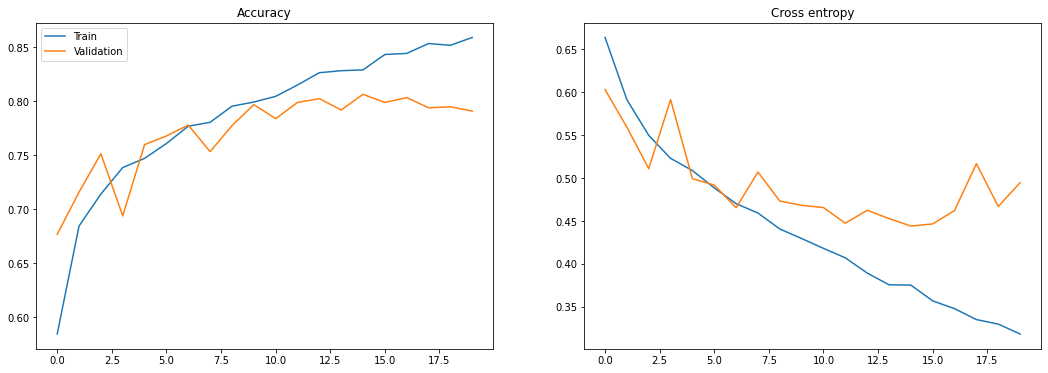

In [16]:
def plot_resultados_training(history):
    fig, axes = plt.subplots(1,2, figsize=(18,6))
    axes[0].plot(history.history['accuracy'], label='Train')
    axes[0].plot(history.history['val_accuracy'], label='Validation')
    axes[0].legend()
    axes[0].set_title('Accuracy')
    axes[1].plot(history.history['loss'], label='Train')
    axes[1].plot(history.history['val_loss'], label='Validation')
    axes[1].set_title('Cross entropy')
plot_resultados_training(history1)

In [17]:
classifier.save('.\\models\\clasificador1')

INFO:tensorflow:Assets written to: .\models\clasificador1\assets


## 3. Cómo hacer nuevas predicciones

In [18]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img(cat_or_dog_path, target_size = frame_size)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
training_dataset.class_indices
if result[0][0] == 1:
    prediction = 'dog'
else:
    prediction = 'cat'

print(prediction)


dog
